# Import software libraries

In [18]:
# Import required libraries.
import sys                                                  # Read system parameters.
import numpy as np                                          # Work with multi-dimensional arrays.
import pandas as pd                                         # Manipulate and analyze data.
import matplotlib                                           # Create and format charts.
import matplotlib.pyplot as plt  
import seaborn as sns                                       # Make charting easier.
import sklearn                                              # Train and evaluate machine learning models.
from sklearn.model_selection import train_test_split, \
                                    learning_curve, \
                                    cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, \
                            explained_variance_score, \
                            mean_absolute_error, \
                            mean_squared_error
from sklearn.dummy import DummyRegressor
import xgboost                                              # Build gradient boosting models.
from xgboost import XGBRegressor
import pickle                                               # Save Python objects as binary files.
from collections import Counter
import warnings                                             # Suppress warnings.
warnings.filterwarnings('ignore')

# Ensure results are reproducible.
np.random.seed(1)

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Seaborn {}'.format(sns.__version__))
print('- scikit-learn {}'.format(sklearn.__version__))
print('- XGBoost {}'.format(xgboost.__version__))

Libraries used in this project:
- Python 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
- NumPy 1.26.4
- pandas 2.2.1
- Matplotlib 3.8.0
- Seaborn 0.11.0
- scikit-learn 1.2.2
- XGBoost 2.0.3


In [19]:
import seaborn as sns

In [20]:
from scipy.stats.mstats import winsorize

# Read and examine the data

In [21]:
# Read the data.
customer_data = pd.read_pickle('../data/customer_data_preprocessed.pickle')


# Preview the first five rows of the data.

customer_data.head()

,frequency,recency,monetary_value,num_unique_items,tenure,churned
CustomerID,,,,,,
u12747,11,3,302.76,3,369.0,1.0
u12748,95,2,783.19,10,369.0,0.0
u12749,6,4,251.42,3,130.0,1.0
u1282,1,327,17.70,1,326.0,0.0
u12822,1,88,16.50,1,87.0,1.0


In [22]:
# Check the structure of the data.

customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2130 entries, u12747 to u18283
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   frequency         2130 non-null   int64  
 1   recency           2130 non-null   int64  
 2   monetary_value    2130 non-null   float64
 3   num_unique_items  2130 non-null   int64  
 4   tenure            2130 non-null   float64
 5   churned           2130 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 116.5+ KB


In [23]:
df = customer_data
n_bootstraps = 100

# Initialize an empty list to store bootstrapped samples
bootstrapped_samples = []

# Perform bootstrapping to create new samples
for _ in range(n_bootstraps):
    # Sample with replacement from the original dataset
    bootstrap_sample = df.sample(n=len(df), replace=True)
    # Append the bootstrapped sample to the list
    bootstrapped_samples.append(bootstrap_sample)

# Concatenate the bootstrapped samples into a single DataFrame
bootstrapped_df = pd.concat(bootstrapped_samples, ignore_index=True)

# Reset the index of the bootstrapped DataFrame
bootstrapped_df.reset_index(drop=True, inplace=True)

# Now 'bootstrapped_df' contains the expanded dataset with bootstrapped samples

In [24]:
customer_data = bootstrapped_df

# Prepare the data

In [25]:
# Define the target variable and get the count of each value in the variable.
customer_data.monetary_value.describe()




count    213000.000000
mean        154.119585
std         450.426806
min           0.550000
25%          18.750000
50%          48.600000
75%         131.900000
max       10281.200000
Name: monetary_value, dtype: float64

In [26]:
customer_data.describe()

,frequency,recency,monetary_value,num_unique_items,tenure,churned
count,213000.000000,213000.000000,213000.000000,213000.000000,213000.000000,213000.000000
mean,5.504216,107.359995,154.119585,2.533653,214.481944,0.351742
std,8.603438,99.794488,450.426806,1.649888,112.950909,0.477515
min,1.000000,1.000000,0.550000,1.000000,1.000000,0.000000
25%,1.000000,25.000000,18.750000,1.000000,110.000000,0.000000
50%,3.000000,72.000000,48.600000,2.000000,239.000000,0.000000
75%,6.000000,170.000000,131.900000,3.000000,311.000000,1.000000
max,171.000000,374.000000,10281.200000,10.000000,373.000000,1.000000


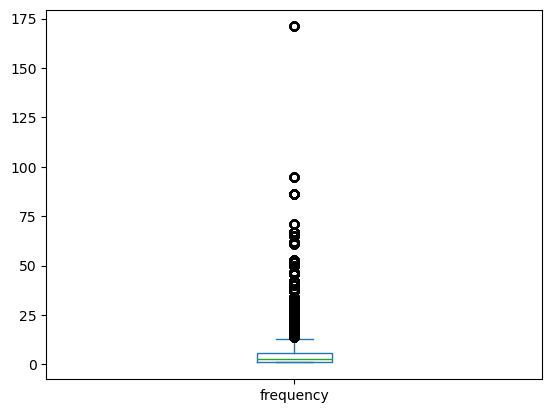

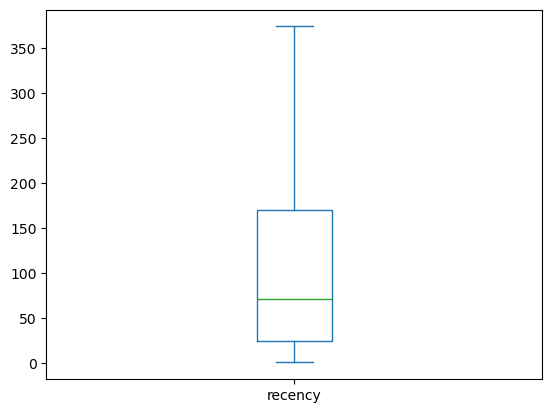

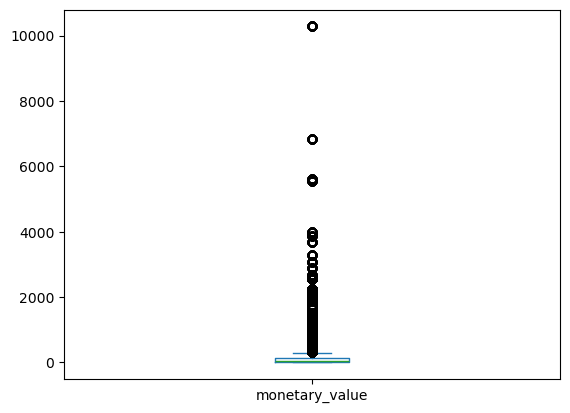

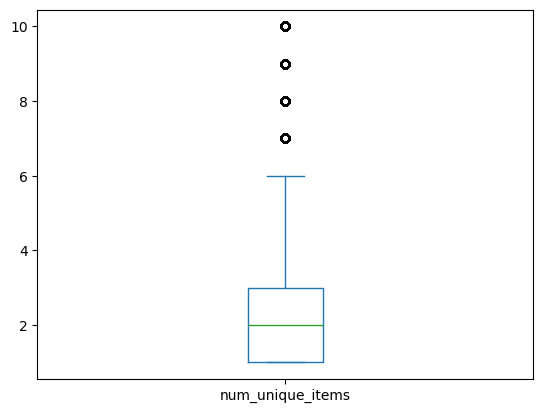

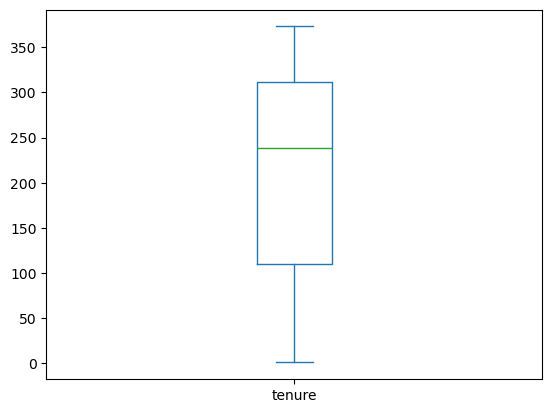

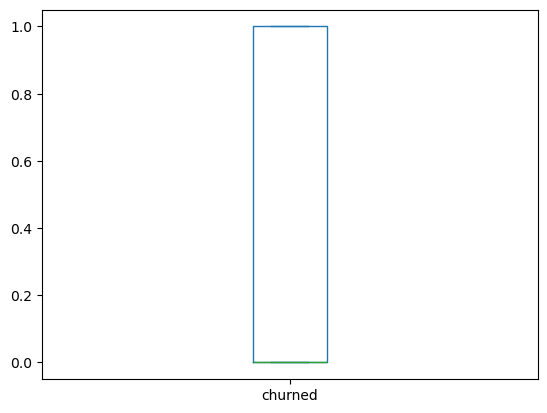

In [27]:
# # Plot a histogram of the target variable distribution.
# for col in customer_data.columns:
#     percentile_75 = np.percentile(customer_data[col], 85)
#     plt.figure()  # Create a new figure for each box plot
#     plt.boxplot(customer_data[col][customer_data[col] <= percentile_75])
#     plt.title(f'Box Plot for {col} (95th percentile)')
#     plt.show()  # Display the box plot for each column
for col in customer_data.columns:
    customer_data[col].plot(kind="box")
    plt.show()

In [28]:
# Split the data into target and features.
target= customer_data.monetary_value
features = customer_data.drop(['monetary_value'],axis=1)

In [29]:
# Split the dataset into separate training and testing sets.

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3)




# Get the shape of both the training dataset and the test dataset.

X_train.shape,X_test.shape,y_train.shape,y_test.shape







((149100, 5), (63900, 5), (149100,), (63900,))

In [30]:
X_train["frequency"] = winsorize(X_train['frequency'], limits=[0, 0.05])

In [31]:
# Get summary statistics for the target variable (test data).
# Count, mean, standard deviation, minimum, maximum, etc.

y_test.describe()

count    63900.000000
mean       152.216800
std        435.440385
min          0.550000
25%         18.750000
50%         48.600000
75%        131.900000
max      10281.200000
Name: monetary_value, dtype: float64

# Standardize the test and training data

In [32]:
# Standardize the training data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


# Standardize the test data as well.
X_test_scaled = scaler.fit_transform(X_test)

# Compare evaluation metrics for each model

In [33]:
# List will hold model objects.

models = []

# Dummy Classifier used as a baseline algorithm.

models.append(('Dummy Regressor', DummyRegressor()))

# Linear Regression model.

models.append(('Linear Regression', LinearRegression()))

# Random Forest model.

models.append(('Random Forest', RandomForestRegressor()))

# XGBoost model.

models.append(('XGBoost', XGBRegressor(objective = 'reg:squarederror', n_jobs = 1)))

In [34]:
# List will hold dictionaries of model scores.

scoring_df = []
pred_dict = {}
# Train each model in the list and output multiple scores for each model.

for name, model in models:
    if name in ['Linear Regression']:
        X_train_1 = X_train_scaled
    else:
        X_train_1 = X_train
    
    model.fit(X_train_1, y_train)
    y_pred = model.predict(X_test)
    pred_dict[name] = y_pred
    # Calcualte the evaluation metrics for the model.
    
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    scoring_dict = {'Model': name,
                    'R2': round(r2, 4),
                    'Mean Absolute Error': round(mae, 4), 
                    'Mean Squared Error': round(mse, 4),
                    }
    
    scoring_df.append(scoring_dict)

In [35]:
pd.DataFrame(scoring_df).sort_values("Mean Squared Error")

,Model,R2,Mean Absolute Error,Mean Squared Error
2,Random Forest,0.9997,1.4800,4.945570e+01
3,XGBoost,0.9976,14.0884,4.607208e+02
0,Dummy Regressor,-0.0000,169.0752,1.896128e+05
1,Linear Regression,-593.1628,8084.2800,1.126565e+08


# Begin evaluating the best model

In [36]:
# Retrain the model with the lowest MSE.
rf = RandomForestRegressor()
rf.fit(X_train,y_train)


RandomForestRegressor()

In [37]:
# Make predictions on the test data.
rf_y_pred = rf.predict(X_test)


# Get the first 5 predictions.
rf_y_pred[:5]


array([210.29      ,  22.00654313,  14.85      ,  16.71589464,
        20.92117861])

In [38]:

def residual_plot(model_name):
    # Create DataFrame for residuals
    resid_df = pd.DataFrame({
        'monetary_value': y_test,
        'monetary_pred': pred_dict[model_name],
        'residuals': y_test - pred_dict[model_name]
    })
    
    # Sort by monetary value and add a record number for plotting
    resid_df = resid_df.sort_values('monetary_value').reset_index(drop=True)
    resid_df['record_num'] = np.arange(len(resid_df))
    
    # Plot the actual monetary values and residuals
    plt.figure(figsize=(12, 8))
    plt.plot(resid_df['record_num'], resid_df['monetary_value'], color='red', linewidth=5, label='Actual Monetary Value')
    plt.scatter(resid_df['record_num'], resid_df['residuals'], color='blue', label='Residuals')
    
    # Add title, labels, and legend
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Record Number')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()





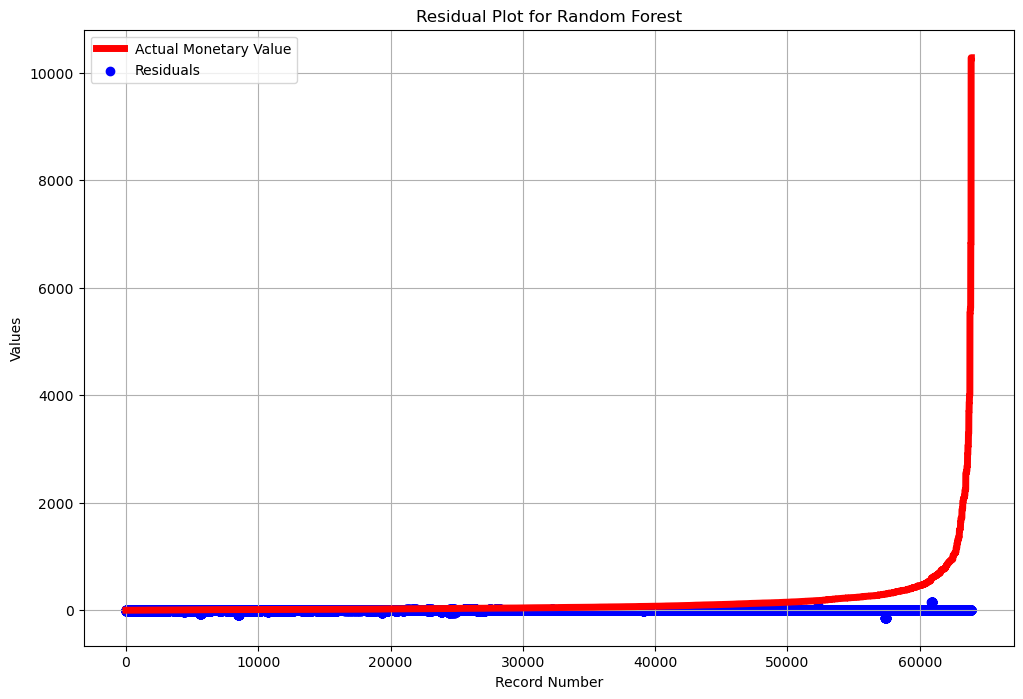

In [39]:
pred_dict["Random Forest"] = rf_y_pred
residual_plot("Random Forest")

# Generate a feature importance plot for the best model

In [40]:
# This function generates a feature importance plot on a bar chart.

def feature_importance_plot(model, X_train, n):
    """Plots feature importance. This only works for random forest and XGBoost models."""
    
    plt.figure(figsize=(8, 5))  # Set figure size.
    feat_importances = pd.Series(model.feature_importances_,
                                 index = X_train.columns)
    feat_importances.nlargest(n).plot(kind = 'barh')
    plt.title(f'Top {n} Features')
    plt.show()

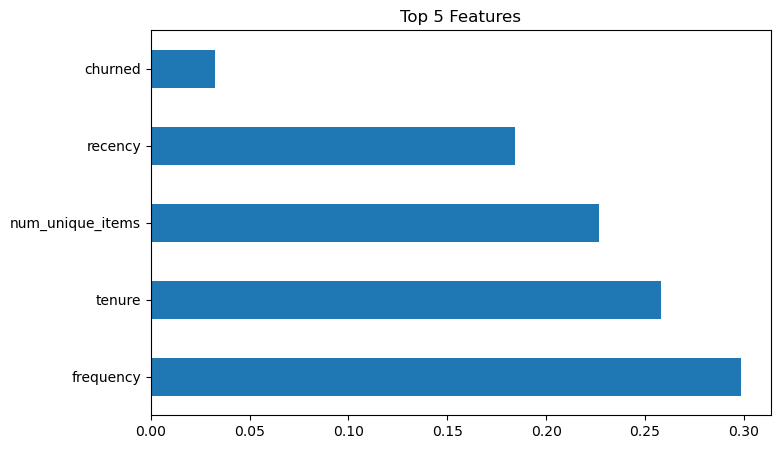

In [41]:
# Plot the feature importances.
feature_importance_plot(rf,X_train,5)


# Plot a learning curve for the best model

In [42]:
# This function generates and plots a learning curve.

def plot_learning_curves(model, X_train, y_train):
    """Plots learning curves for model validation."""
    
    plt.figure(figsize=(5, 5))  # Set figure size.
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X_train,
                                                            y_train,
                                                            cv = 5,  # Number of folds in cross-validation.
                                                            scoring = 'neg_mean_squared_error',  # Evaluation metric.
                                                            n_jobs = 1,
                                                            shuffle = True,
                                                            train_sizes = np.linspace(0.01, 1.0, 5))  # 5 different sizes of the training set.

    # Create means and standard deviations of training set scores.
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    # Create means and standard deviations of test set scores.
    
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    # Find the optimum training size: where the gap between training and cross-validation scores is minimized.
    optimal_idx = np.argmin(np.abs(train_mean - test_mean))
    optimal_size = train_sizes[optimal_idx]
    
    # Annotate the optimum training size.
    plt.annotate(f'Optimum Training Size: {optimal_size}',
                 xy=(optimal_size, test_mean[optimal_idx]),
                 xytext=(optimal_size, test_mean[optimal_idx] + 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center')
    # Draw lines.
    
    plt.plot(train_sizes, train_mean, '--', color = '#111111', label = 'Training score')
    plt.plot(train_sizes, test_mean, color = '#111111', label = 'Cross-validation score')

    # Create plot.
    
    plt.title('Learning Curves')
    plt.xlabel('Training Set Size'), plt.ylabel('Negative MSE'), plt.legend(loc = 'best')
    plt.xlim(40000,140000)
    plt.tight_layout()
    
    plt.show()

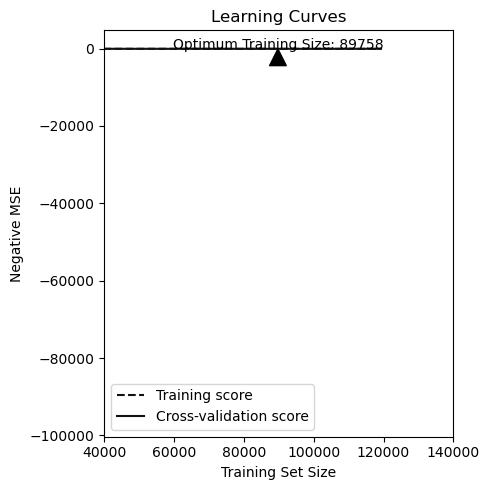

In [43]:
plot_learning_curves(rf,X_train,y_train)

In [44]:
features.shape

(213000, 5)

### Hyper-parameter Tuning

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

In [47]:
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3)

In [48]:
# !pip install hyperopt

# Apply Bayesian Optimization

In [49]:
from hyperopt import hp,fmin,tpe

In [50]:
search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300, 50),
    'max_depth': hp.choice('max_depth', [None, 10, 20]),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 4, 1)  # Generating integers
}


# Define the objective function (to minimize mean squared error)
def objective_function(params):
    params['min_samples_leaf'] = int(params['min_samples_leaf'])  # Ensure integer value
    params['min_samples_split'] = int(params['min_samples_split'])  # Ensure integer value
    params['n_estimators'] = int(params['n_estimators'])  # Ensure integer value
    if params['max_depth']:
        params['max_depth'] = int(params['max_depth'])# Ensure integer value
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return -mean_squared_error(y_test, y_pred)  # Minimize negative mean squared error

# Optimize with Hyperopt (change max_evals for more iterations)
best_params = fmin(fn=objective_function,
                   space=search_space,
                   algo=tpe.suggest,  # TPE algorithm (Tree-Parzen Estimator)
                   max_evals=50)

# Print best hyperparameters
print(f"Best Hyperparameters: {best_params}")

100%|████████████████████████████████████████████████| 50/50 [38:16<00:00, 45.93s/trial, best loss: -6034.447865274217]
Best Hyperparameters: {'max_depth': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 3.0, 'n_estimators': 150.0}


In [51]:
# Create RandomForestRegressor model with the best hyperparameters
tuned_rf = RandomForestRegressor(max_depth=20,min_samples_leaf=1,min_samples_split=3,n_estimators=150)
tuned_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=3, n_estimators=150)

In [52]:
tuned_pred = tuned_rf.predict(X_test)

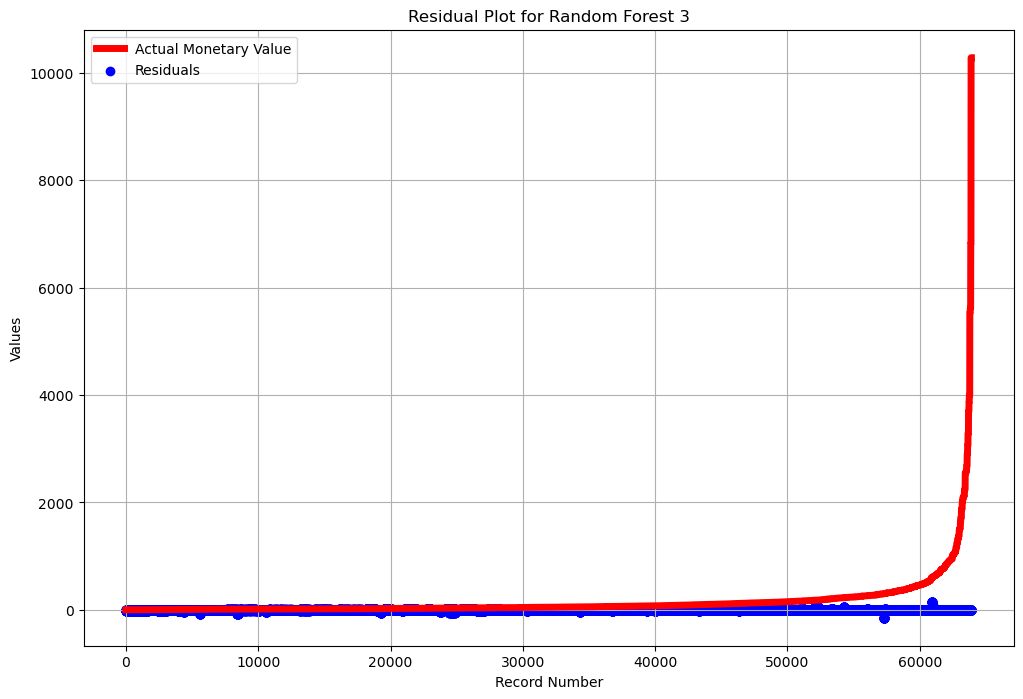

In [53]:
pred_dict["Random Forest 3"] = tuned_pred
residual_plot("Random Forest 3")

In [54]:
name = "Tuned Random Forest"
r2 = r2_score(y_test, tuned_pred)
explained_var = explained_variance_score(y_test, tuned_pred)
mae = mean_absolute_error(y_test, tuned_pred)
mse = mean_squared_error(y_test, tuned_pred)

scoring_dict = {'Model': name,
                'R2': round(r2, 4),
                'Mean Absolute Error': round(mae, 4), 
                'Mean Squared Error': round(mse, 4),
                }

scoring_df.append(scoring_dict)

In [55]:
pd.DataFrame(scoring_df).sort_values("Mean Squared Error")

,Model,R2,Mean Absolute Error,Mean Squared Error
2,Random Forest,0.9997,1.4800,4.945570e+01
4,Tuned Random Forest,0.9997,2.3072,6.557070e+01
3,XGBoost,0.9976,14.0884,4.607208e+02
0,Dummy Regressor,-0.0000,169.0752,1.896128e+05
1,Linear Regression,-593.1628,8084.2800,1.126565e+08


# Tuning XGBoost

In [56]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [57]:

# Initialize XGBRegressor
xgb2 = XGBRegressor()

# Define the parameter grid with distributions
param_distributions = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.19),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'min_child_weight': randint(1, 6)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb2, param_distributions=param_distributions, 
                                   n_iter=100, cv=5, scoring='r2', verbose=2, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best R2 score: ", random_search.best_score_)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'colsample_bytree': 0.821105986734196, 'gamma': 0.17168774075125148, 'learning_rate': 0.1962630009060487, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 259, 'subsample': 0.9404546686067428}
Best R2 score:  0.9992566592459016


In [58]:
best_model = random_search.best_estimator_

In [59]:
best_model.fit(X_train,y_train)
tuned_xgb_pred = best_model.predict(X_test)

In [60]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.821105986734196, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.17168774075125148,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1962630009060487,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=259, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

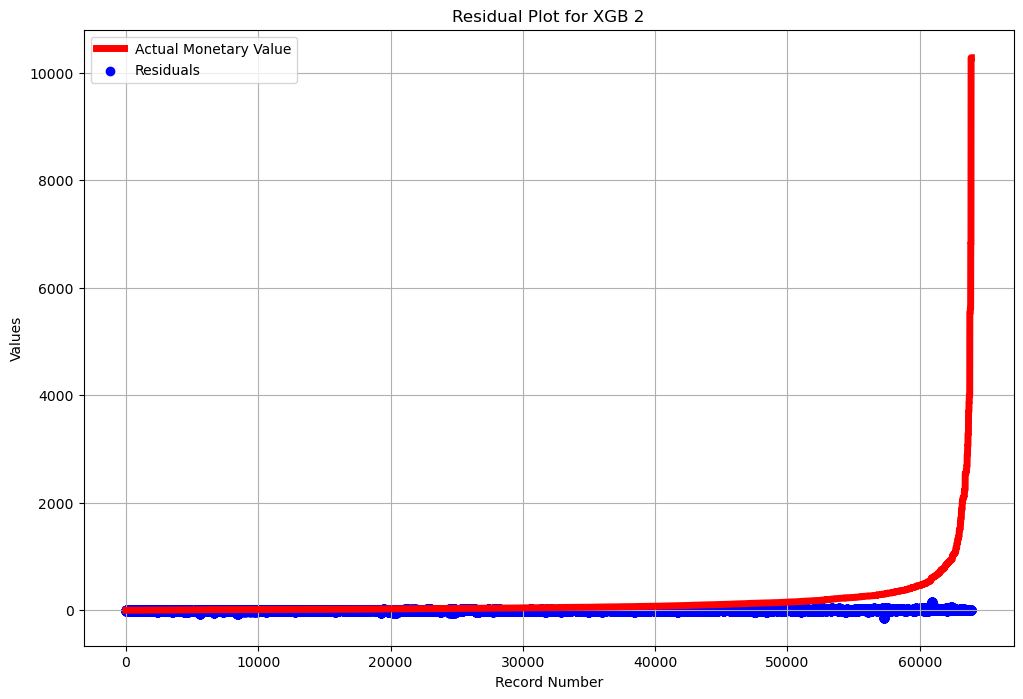

In [61]:
pred_dict["XGB 2"] = tuned_xgb_pred
residual_plot("XGB 2")

In [62]:
name = "Tuned XGBoost"
r2 = r2_score(y_test, tuned_xgb_pred)
explained_var = explained_variance_score(y_test, tuned_xgb_pred)
mae = mean_absolute_error(y_test, tuned_xgb_pred)
mse = mean_squared_error(y_test, tuned_xgb_pred)

scoring_dict = {'Model': name,
                'R2': round(r2, 4),
                'Mean Absolute Error': round(mae, 4), 
                'Mean Squared Error': round(mse, 4),
                }

scoring_df.append(scoring_dict)

In [63]:
scoring_df = pd.DataFrame(scoring_df).sort_values("Mean Squared Error")

In [64]:
scoring_df

,Model,R2,Mean Absolute Error,Mean Squared Error
2,Random Forest,0.9997,1.4800,4.945570e+01
4,Tuned Random Forest,0.9997,2.3072,6.557070e+01
5,Tuned XGBoost,0.9992,7.7077,1.517436e+02
3,XGBoost,0.9976,14.0884,4.607208e+02
0,Dummy Regressor,-0.0000,169.0752,1.896128e+05
1,Linear Regression,-593.1628,8084.2800,1.126565e+08


In [65]:
best_model = rf

In [66]:
best_model

RandomForestRegressor()

# Save the best model

In [67]:
# Save the best model as a pickle file named best_regression_model.pickle.

pickle.dump(best_model,open('../models/best_regression_model.pickle','wb'))